#  Weather in AUS
#### Hila Dar, Feb 2022

1. [Introduction](#Introduction) 
2. [Data Analysis and Data Visualization](#Data_Analysis_and_Data_Visualization)
3. [Preprocessing](#Preprocessing)
4. [Feature Creation / Selection](#Feature)
5. [Random Forest - Training](#RF)

## Introducation <a class="anchor" id="Introduction"></a> <a class="tocSkip">

### Problem definition <a class="anchor" id="1.1"></a>

**goal**: 
Predict next-day rainfall in Australia using location specific data. 

**data**: 
10-years dailly weather obersavation from different locations. These observations have been taken from the Bureau of Meteorology's "real time" system. Most of the data are generated and handled 

**model** 
random forest

**summary** 

1. Econding Wind direction: I had to consider how to encode/represent angle degree values (0-360 degress) in a continuous and periodic way  (epsilon degrees should be near -epsilon degress). I chose to map the angle to the pair:
$f: f(\theta) = (\sin(\theta), \cos(\theta))$

2. Morning and afternoon: The data contains morning and afternoon features, which are inherently correlated. If $x_{AM}$ and $x_{PM}$ are the morning the afternoon fields, I chose to apply the following map:
$(x_{AM}, x_{PM}) \to (x_{PM}, x_{PM}-x_{AM})$. In that sense, I only used the uncorrealted component of the morning fields.

3. Missing Values: I used three-stage process to fill missing values. First, using the strong auto-correaltion of the fields, I completed the missing values by the n-previous-days mean (if possible). Next, using the seasonality of the fields, I filled the remaining missing values by the mean value of the field in the same month and location. Finally I dropped the remaining nan values.

4. objective function - I care more about precision (predicting Rain when it's raining), and hence optimize for f1-score (rather than accuracy).

5. Training & Selection - I trained a random forest using randomized grid search. I used oversamppling to overcome imbalance problems. I chose optimal paramers for the model using CV and chose the prediciton threshold that maximizes the f1 score.


==== Test ==== 

              precision    recall  f1-score   support

     no_rain       0.92      0.88      0.90      8857
        rain       0.63      0.72      0.67      2463

    accuracy                           0.85     11320


##### Libraries  <a class="anchor" id="1.3"></a>

In [394]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


In [395]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
from datetime import datetime
import folium

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# map
from geopy.geocoders import Nominatim
import re


# machine learning
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_score,roc_curve,roc_auc_score, recall_score, accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

#warnings 
import warnings
pd.options.mode.chained_assignment = None  # default='warn'
warnings.filterwarnings('ignore')


CMAP = 'vlag'
fontfamily = "monospace"
context = "notebook"

color_main = 'gold'
my_colors = [color_main, 'salmon', 'wheat', 'red']


rc = {'axes.titlesize':18, 'axes.titleweight':'bold',
      'axes.labelweight':'bold', 'figure.figsize':[12,8], 
      'lines.linewidth':5, 'axes.edgecolor':'black',
     'boxplot.boxprops.color': color_main}

sns.set(context=context, font=fontfamily, rc=rc, style="whitegrid")
sns.set_palette(CMAP)

##### Loading the Data <a class="anchor" id="1.4"></a>

In [396]:
# loading the data
data_path = "./weatherAus.csv"
data = pd.read_csv(data_path)
print(f"there are {data.duplicated().sum()} duplicated data-points")

# simple pre processing
def to_datetime(stry):
    """ converts date to datetime """
    time = stry.split('-')
    year,month,day = int(time[0]), int(time[1]),int(time[2])
    return datetime(year = year, month=month, day=day).date()

data["Date"] = data["Date"].apply(to_datetime) # converts to datetime
data = data.sort_values("Date")  # sorts by date
data = data.set_index('Date')    # sets index
data = data.replace(to_replace=["Yes","No"], value = [1,0])  # converts bool to int

# wind categorial values to degree:
# categorical values to degress:
d = {"E": 0,
     "ESE": 22.5,
     "SE": 45,
     "SSE": 67.5,
     "S": 90,
     "SSW": 112.5,
     "SW": 135,
     "WSW": 157.5,
     "W": 180,
     "WNW": 202.5,
     "NW": 225,
     "NNW": 247.5,
     "N": 270,
     "NNE": 292.5,
     "NE": 315,
     "ENE": 337.5}

def f(v): return v* (np.pi/180)
d = dict((k, f(v)) for k, v in d.items())
data.replace(to_replace=list(d.keys()), value = list(d.values()), inplace = True)

# split to y-label and train and test.
y_label = 'RainTomorrow'
train, test = train_test_split(data, test_size=0.2, random_state=1)

there are 0 duplicated data-points


# Exploratory data analysis & Data Visualization <a class="anchor" id="Data_Analysis_and_Data_Visualization"></a>

## Simple Data Analysis <a class="anchor" id="2.1"></a>

### Features Dictionary
| Feature       | Description                                                                                                         | Units               |
|:---------------|:---------------------------------------------------------------------------------------------------------------------|:---------------------|
| Date          | The date of observation                                                                                             | yyyy-mm-dd          |
| Location      | The common name of the location of the weather station                                                              |                     |
| MinTemp       | Minimum temperature in the 24 hours to 9am. Sometimes only known to the nearest whole degree                        | degrees Celsius     |
| MaxTemp       | Maximum temperature in the 24 hours from 9am. Sometimes only known to the nearest whole degree.                     | degrees Celsius     |
| Rainfall      | Precipitation (rainfall) in the 24 hours to 9am. Sometimes only known to the nearest whole millimetre.              | millimetres         |
| Evaporation   | "Class A" pan evaporation in the 24 hours to 9am                                                                    | millimetres         |
| Sunshine      | The number of hours of bright sunshine in the day.| hours               |
| WindGustDir   | Direction of strongest gust in the 24 hours to midnight                                                             | 16 compass points   |
| WindGustSpeed | Speed of strongest wind gust in the 24 hours to midnight                                                            | kilometres per hour |
| WindDir9am    | Wind direction averaged over 10 minutes prior to 9 am                                                               | 16 compass points   |
| WindDir3pm    | Wind direction averaged over 10 minutes prior to 3 pm                                                               | 16 compass points   |
| WindSpeed9am  | Wind speed averaged over 10 minutes prior to 9 am                                                                   | kilometres per hour |
| WindSpeed3pm  | Wind speed averaged over 10 minutes prior to 3 pm                                                                   | kilometres per hour |
| Humidity9am   | Relative humidity at 9 am                                                                                           | percent             |
| Humidity3pm   | Relative humidity at 3 pm                                                                                           | percent             |
| Pressure9am   | Atmospheric pressure reduced to mean sea level at 9 am                                                              | hectopascals        |
| Pressure3pm   | Atmospheric pressure reduced to mean sea level at 3 pm                                                              | hectopascals        |
| Cloud9am      | Fraction of sky obscured by cloud at 9 am                                                                           | eighths             |
| Cloud3pm      | Fraction of sky obscured by cloud at 3 pm                                                                           | eighths             |
| Temp9am       | Temperature at 9 am                                                                                                 | degrees Celsius     |
| Temp3pm       | Temperature at 3 pm                                                                                                 | degrees Celsius     |
| RainToday     | 1 if precipitation (mm) in the 24 hours to 9am exceeds 1mm, otherwise 0                                             | Boolean             |
| RainTomorrow     | The feature we are trying to predict - 1 if precipitation (mm) in the next 24 hours to 9am exceeds 1mm, otherwise 0 | Boolean             |


#### Which features are categorical? Which features are numerical?

In [397]:
categorial_features = train.select_dtypes(include=['object']).columns.tolist()
numerical_features = train.select_dtypes(exclude=['object']).columns.tolist()

print(f'Categorical features: {categorial_features}')
print(f'Numerical features: {numerical_features}')

Categorical features: ['Location']
Numerical features: ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow']


#### Which features contain blank, null or empty values?
* There are many missing data points in this dataset, particularly in some features such as Sunshine and Evaporation.
* As shown below, some features are missing as a whole for some locations.
* Null values have no predictive power of whether it is going to rain.

In [398]:
# checking correaltion between missing values and y_label
tmp = (train.isnull().sum().sort_values(ascending=False)/(train.shape[0]))
features_with_many_nan_values = tmp[tmp > 0.2].index
tmpy = train[~train[y_label].isnull()].copy()

    # checking null values per features: 
null_train = (train.isnull().sum().sort_values(ascending=False)/(train.shape[0])).round(2)
null_test = (test.isnull().sum().sort_values(ascending=False)/(test.shape[0])).round(2)


for feature in features_with_many_nan_values:
    tmpy["{}_is_null".format(feature)] = tmpy[feature].apply(lambda x:1 if pd.isnull(x) else 0)
    corr = np.corrcoef(tmpy["{}_is_null".format(feature)],tmpy[y_label])[0][1]
    print(f"correlation between {feature}_is_null and y_label = {corr:.2f}")
pd.DataFrame({"%-missing values - Train":null_train,"%-missing values - Test":null_test}).sort_values("%-missing values - Train", ascending=False).head(15)


correlation between Sunshine_is_null and y_label = -0.01
correlation between Evaporation_is_null and y_label = 0.01
correlation between Cloud3pm_is_null and y_label = -0.04
correlation between Cloud9am_is_null and y_label = -0.03


,%-missing values - Train,%-missing values - Test
Sunshine,0.48,0.48
Evaporation,0.43,0.43
Cloud3pm,0.41,0.40
Cloud9am,0.38,0.38
Pressure3pm,0.10,0.10
Pressure9am,0.10,0.10
WindGustSpeed,0.07,0.07
WindGustDir,0.07,0.07
WindDir9am,0.07,0.08
Humidity3pm,0.03,0.03


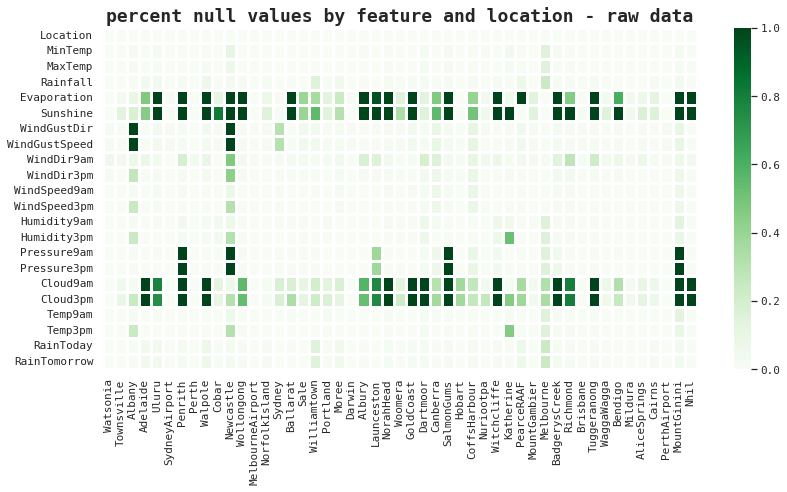

In [399]:
def plot_nan_heatmap(dff, title_surfix):
    """ ploting percent nan values per location and field """
    title = "percent null values by feature and location - " + title_surfix
    tmp = {}
    all_locations = dff.Location.unique()
    for location in all_locations:
        tmp[location] = dff[dff['Location']==location].isnull().sum()/dff[dff['Location']==location].shape[0]
    plt.figure(figsize=(12,7))
    ax = sns.heatmap(pd.DataFrame(tmp ,index = dff.columns),xticklabels=all_locations,linewidths=3, cmap='Greens')
    ax.set_title(title)
    ax.figure.tight_layout()
    
plot_nan_heatmap(train, "raw data")

## Analyze by visualizing data <a class="anchor" id="2.2"></a>

### Features Distribution  & Joint Distribution<a class="anchor" id="2.2.2"></a>

* Temperature and pressure variables are normally distributed.
* Wind speed, evaporation and rainfall variables are right skewed.
* Some variables varies during the day (Wind direction, temprature) and some doesn't vary significantly (cloudiness, pressure, humidity).
* Sunshine and humidity distributions, changes significantly while conditioning our y label.
* our dataset is imbalanced - Most days (78%) it wasn't raining on the next day.

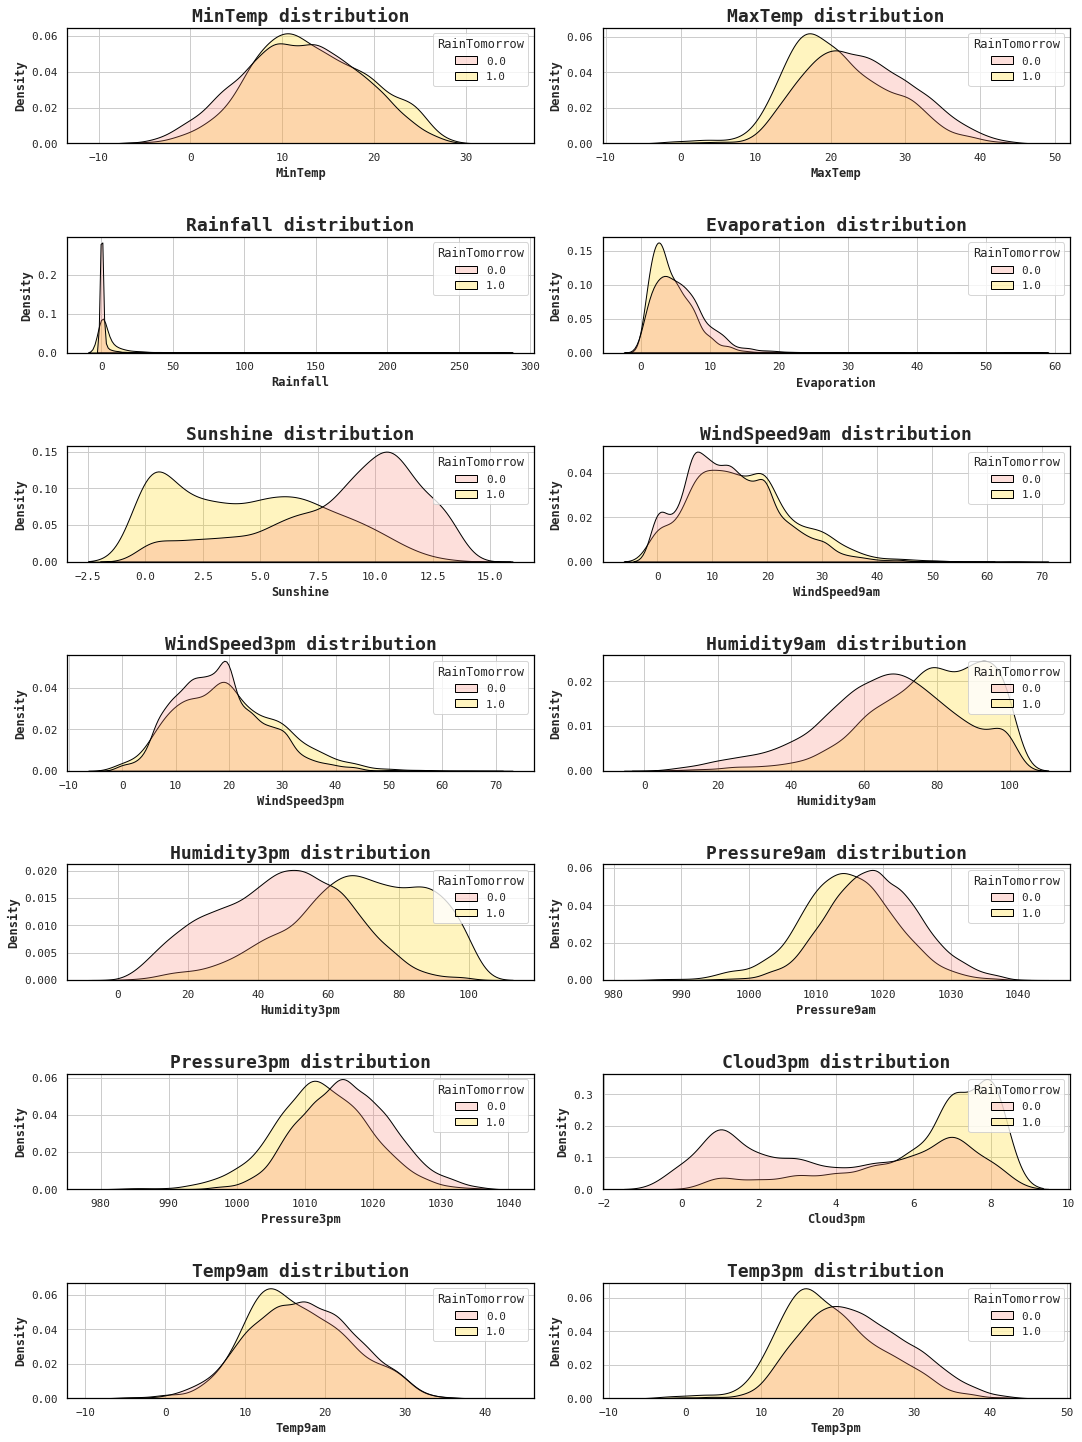

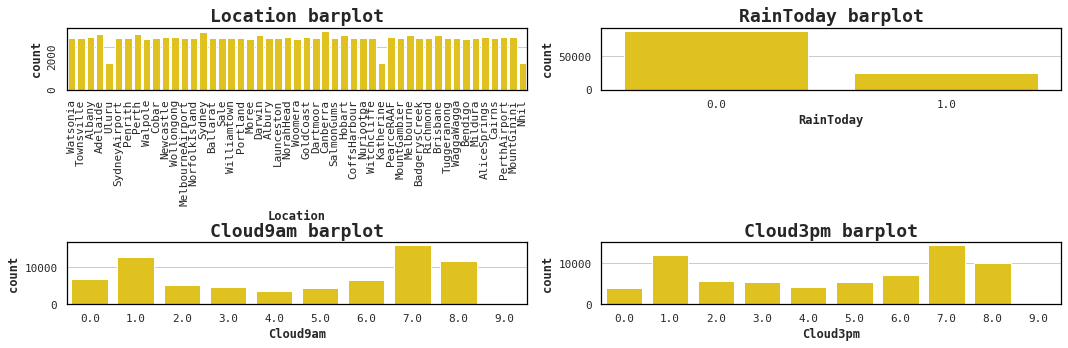

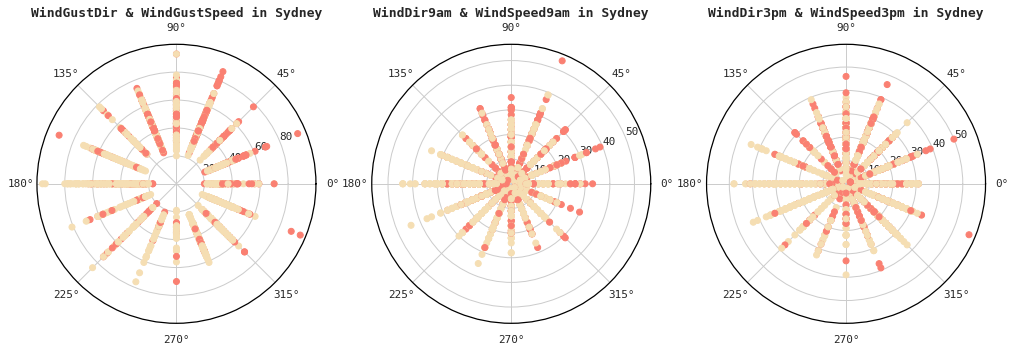

<Figure size 864x576 with 0 Axes>

In [400]:
# Dist plot of all numberical features
fig, ax = plt.subplots(ncols=2, nrows=7, figsize=(15,20))
index = 0
ax = ax.flatten()
title = "numerical features distribution"
sample = train.sample(10000).reset_index()

for col, value in sample.select_dtypes('number').items():
    if col not in ['RainToday', 'RainTomorrow','Cloud9am',"Date",'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm']:
        sns.kdeplot(data=sample, x=col,common_norm=False,hue=y_label,
                    palette={1:color_main,0:my_colors[1]},shade=True, edgecolor="black",
                    ax=ax[index]).set_title(f"{col} distribution", weight="bold")
        index += 1
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=3.0)
plt.savefig(f"./images/{title}.png") 


# Dist plot of all categorial features
title = "categorial features distribution"
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(15,5))
index = 0
ax = ax.flatten()
categorical_features = [col for col in list(train.select_dtypes('object').columns) if col!='Date'] + ['RainToday', 'Cloud9am', 'Cloud3pm']
for col in categorical_features:
    sns.countplot(x=col, data=train,ax=ax[index],alpha=1,color=color)
    ax[index].set_title(f"{col} barplot")
    ax[index].set_xlabel(f"{col}", weight="bold")
    ax[index].set_ylabel("count", weight="bold")
    index += 1
ax[0].tick_params(labelrotation=90)
plt.tight_layout(h_pad=0.0001)
plt.savefig(f"./images/{title}.png") 

# plot wind features:
title = "wind direction & speed"
colors = {1.0:'tab:blue', 0.0:'tab:orange'}
fig= plt.figure(figsize=(17,10))
ax1 = plt.subplot(131, projection='polar')
ax2 = plt.subplot(132, projection='polar')
ax3 = plt.subplot(133, projection='polar')
location = 'Sydney'
tmp = train[train['Location']==location]
series_colors = tmp[y_label].apply(lambda x: my_colors[1] if x==1 else my_colors[2])
ax1.scatter(x=tmp['WindGustDir'], y=tmp['WindGustSpeed'], c=series_colors)
ax2.scatter(x=tmp['WindDir9am'], y=tmp['WindSpeed9am'], c=series_colors)
ax3.scatter(x=tmp['WindDir3pm'], y=tmp['WindSpeed3pm'], c=series_colors)
ax1.set_title(f'WindGustDir & WindGustSpeed in {location}', fontsize=13)
ax2.set_title(f'WindDir9am & WindSpeed9am in {location}',fontsize=13)
ax3.set_title(f'WindDir3pm & WindSpeed3pm in {location}',fontsize=13)
plt.show()
plt.savefig(f"./images/{title}.png") 

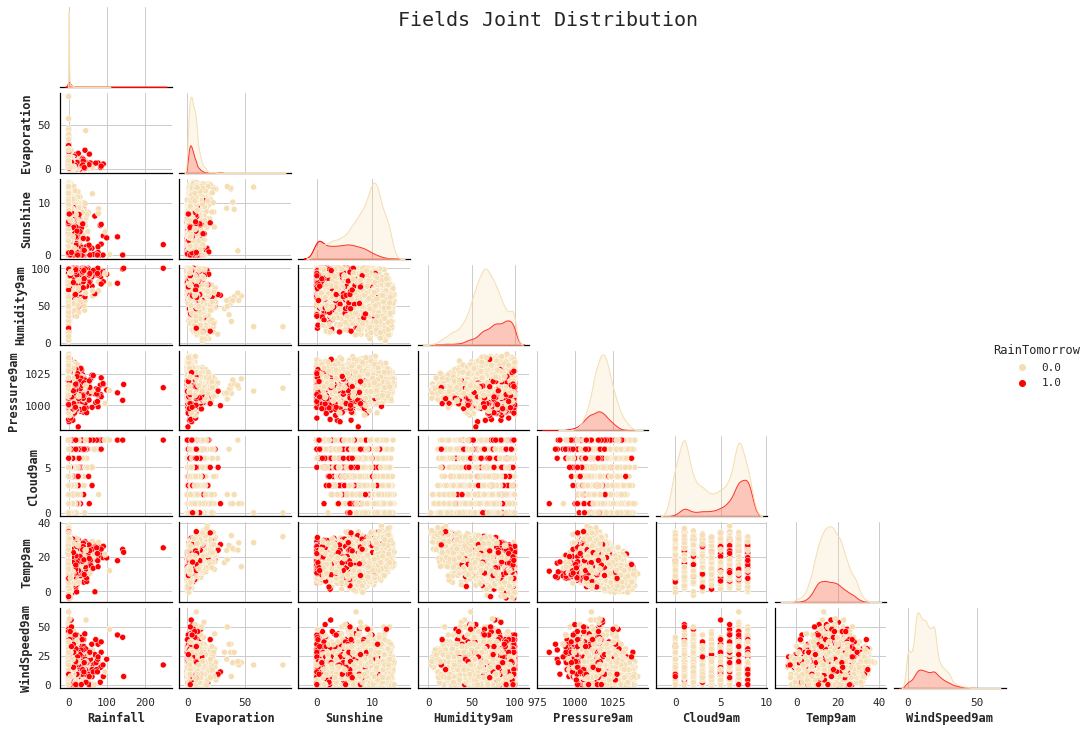

In [401]:
# select only a subset of fields to visualize 
sample_features = [
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'Humidity9am',
 'Pressure9am',
 'Cloud9am',
 'Temp9am',
 'WindSpeed9am']
data_sample = train[sample_features+[y_label]].reset_index().sample(10000)

title = "Fields Joint Distribution"
f = sns.pairplot(data=data_sample,
                 vars=(sample_features),
                 hue=y_label,
                 palette={1:my_colors[3],0:my_colors[2]}, 
                 diag_kind = 'kde',
             corner=True)
f.fig.set_size_inches(15,10)
f.fig.suptitle(title, fontsize=20)
plt.savefig(f"./images/{title}.png") 

### Features Correlation <a class="anchor" id="2.2.2"></a>

* Many of our features such as temperature, pressure, cloud, windspeed and humidity, have correalation between their morning and afternoon values.
* The most linear correlated features with RainTomorrow are: Sunshine (-0.45), Humidity3pm (0.45), Cloud3pm(0.38),Cloud9am (0.32) and RainToday (0.31).

The most linear correlated features with RainTomorrow are:
Sunshine          -->  0.45 (abs)
Humidity3pm       -->  0.45 (abs)
Cloud3pm          -->  0.38 (abs)
Cloud9am          -->  0.32 (abs)
RainToday         -->  0.31 (abs)
Humidity9am       -->  0.26 (abs)
Pressure9am       -->  0.25 (abs)
Rainfall          -->  0.24 (abs)
WindGustSpeed     -->  0.23 (abs)
Pressure3pm       -->  0.23 (abs)


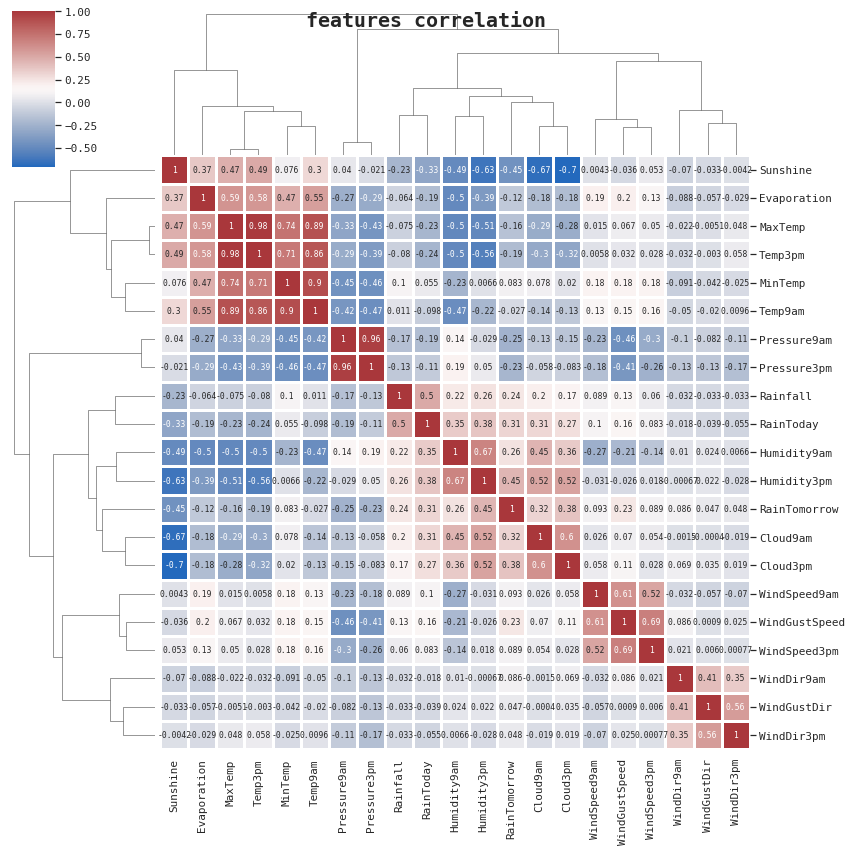

In [402]:
def plot_features_correlation(dff,title = "features correlation"):
    ax = sns.clustermap(dff.corr(), annot=True, cmap='vlag',fmt='.2g',linewidths=3, figsize=(12,12), annot_kws={"fontsize":8})
    if y_label in dff.columns:
        series = np.abs(dff.corr()[y_label]).sort_values(ascending=False)
        print('The most linear correlated features with RainTomorrow are:')
        for i, row in enumerate(series):
            if 0.2 <= row < 1:
              print(f'{series.index[i]:17} --> {row: .2f} (abs)')
    ax.fig.suptitle(title, fontsize=20, weight="bold")
    plt.savefig(f"./images/{title}.png") 
plot_features_correlation(train)

### Location analysis<a class="anchor" id="2.2.3"></a>

* Most observations were taken from south east Australia (which is also the most populated area in Australia). 
* Distribuations of features varies accross locations, as expected - the locations of the stations belongs to different climate zones. 
* If we look at the avarege dailly temprature range per location, we see that desert locations have the largest range, while coastal regions seem to be a bit more stable.

In [403]:
#Locations of the observations, with average rainfall per location.

geolocator = Nominatim(user_agent="hila_dar")
all_locations = train.Location.unique()
rows = []
for location in all_locations:
    fixed_location = re.sub(r'([a-z](?=[A-Z])|[A-Z](?=[A-Z][a-z]))', r'\1 ', location) #Some location names in the data composed of 2 words, but missing the space between them. 
    address = f'{fixed_location}, Australia' 
    loc = geolocator.geocode(address)
    if loc:
        rows.append([location, loc.latitude, loc.longitude])
    else:
        rows.append([location, None, None])
        
locations_df = pd.DataFrame(rows, columns = ['Location', 'lat','long']).set_index('Location')
locations_df = pd.concat([train.groupby('Location').agg({'Rainfall':'mean'}), locations_df],axis=1, join='inner')

m = folium.Map(location = [-29, 151.2], tiles ='OpenStreetMap', zoom_start=4)
for index, row in locations_df.iterrows():
   folium.Circle(
      location=[row['lat'], row['long']],
      popup=index,
      radius=float(row['Rainfall'])*20000,
      color='crimson',
      #fill=True,
      fill_color='crimson'
   ).add_to(m)
m



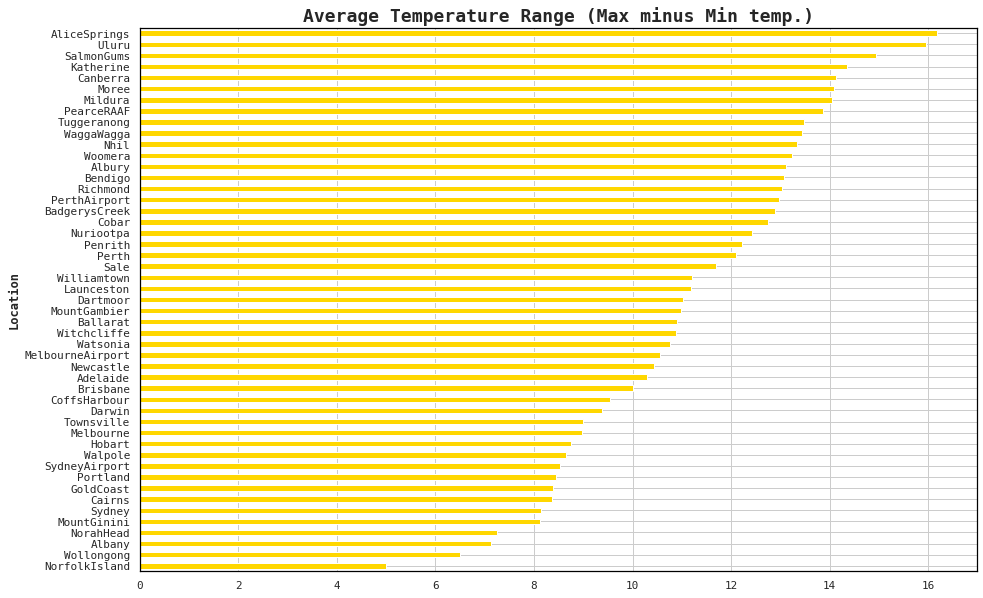

In [404]:
# plot dailly range of tempreature by location (Max temp minus Min temp) 
tmp = train
title="Average Temperature Range (Max minus Min temp.)"
tmp["dailly_range"] = tmp['MaxTemp']-tmp['MinTemp']
temp_avg = tmp.groupby(['Location']).mean()
temp_avg.sort_values(by='dailly_range', ascending=True)['dailly_range'].plot(kind='barh', figsize=(15,10),color=color,title=title)
plt.savefig(f"./images/{title}.png") 
plt.show()

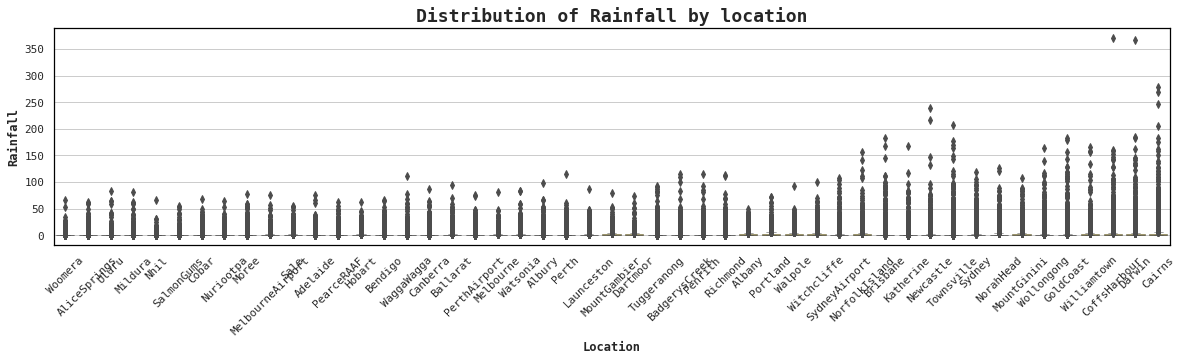

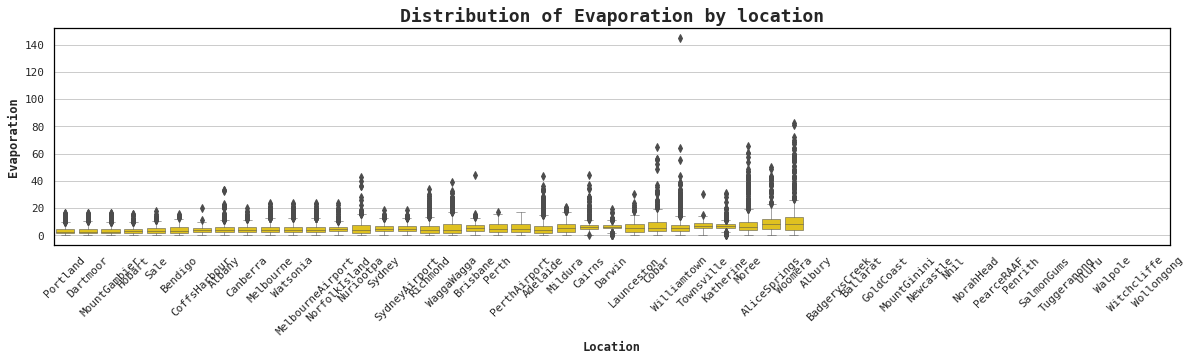

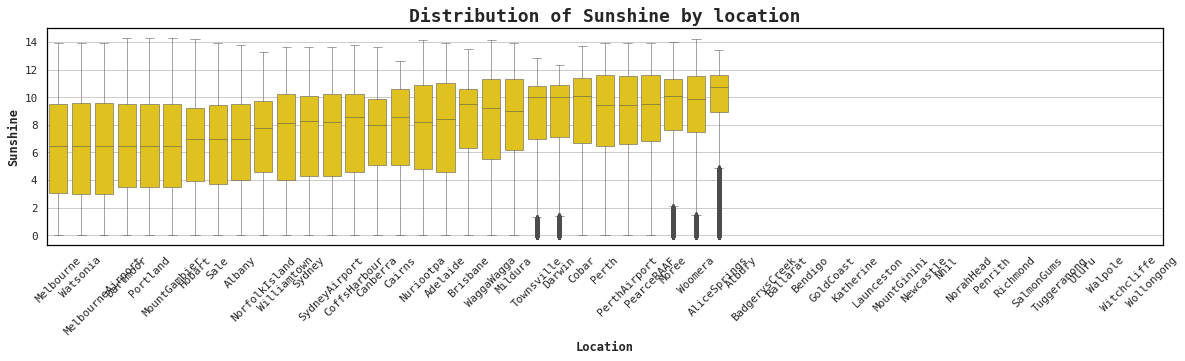

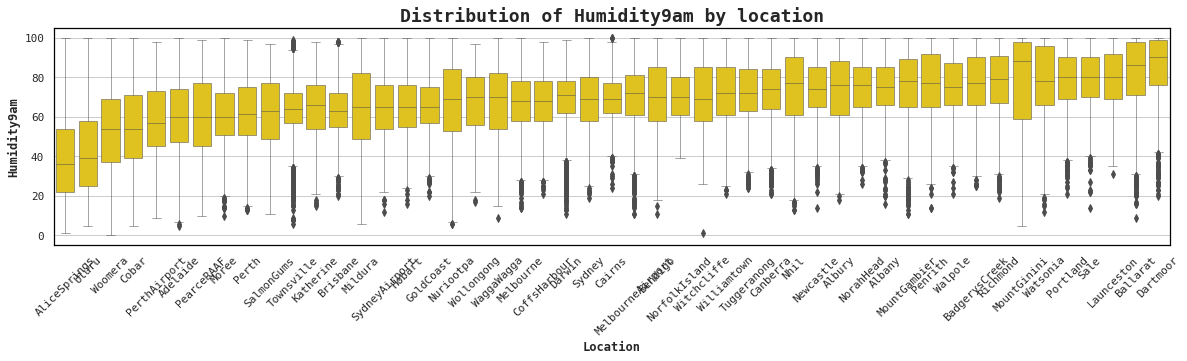

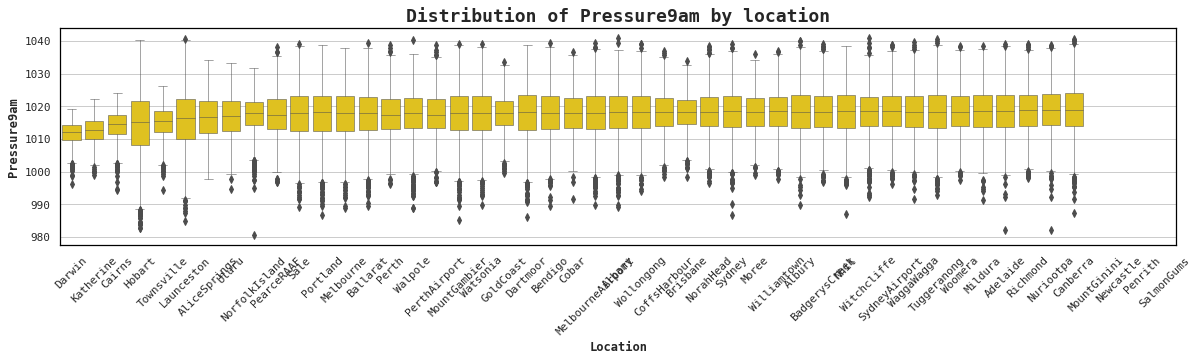

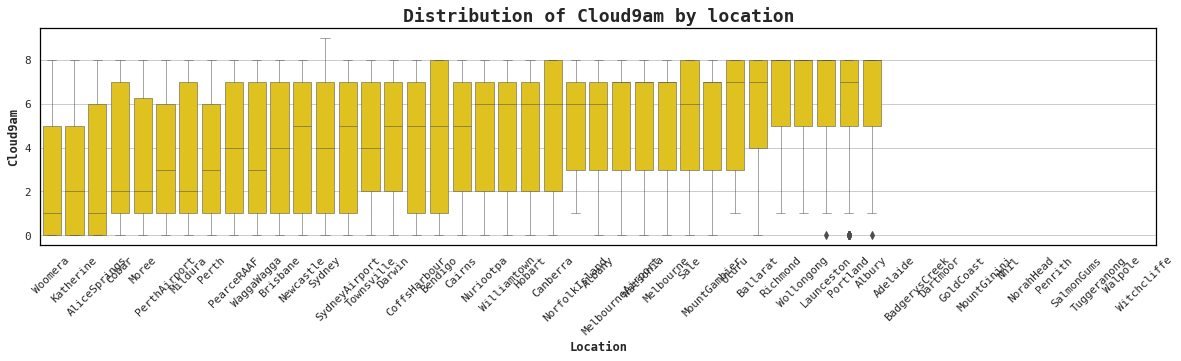

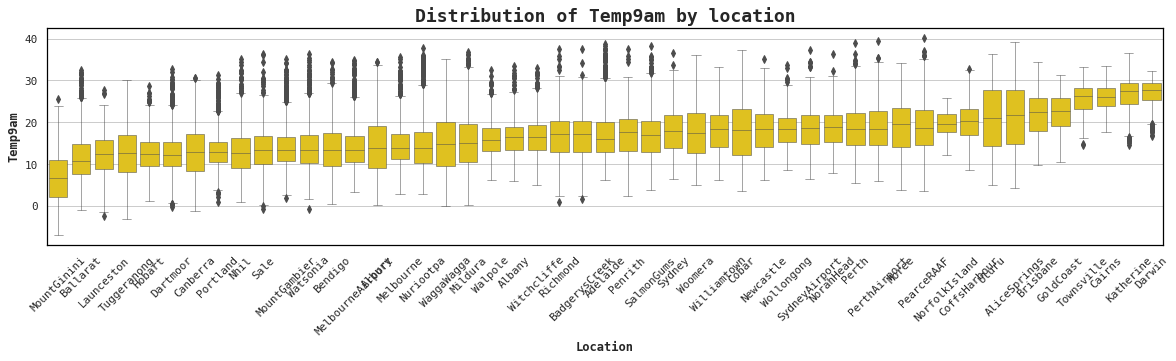

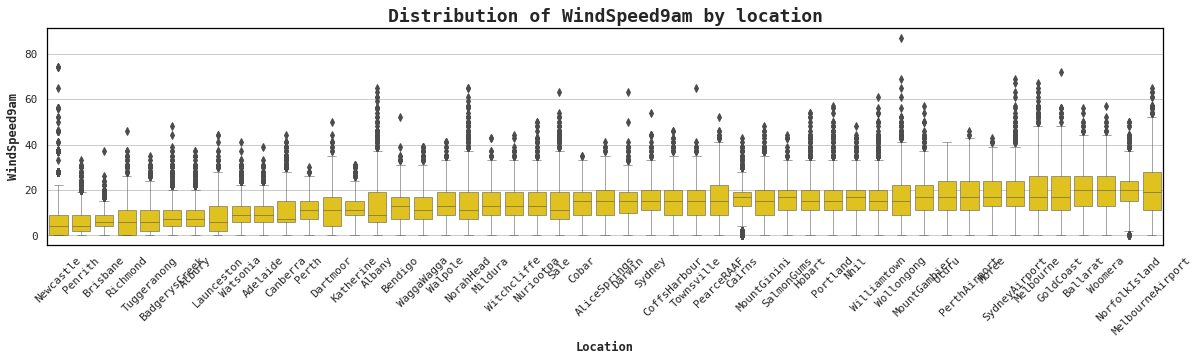

In [405]:
def plot_field_dist_by_location(field):
    #plot settings:
    plt.figure(figsize=(20,4))
    my_order = train.groupby('Location')[field].mean().sort_values().index
    plt.xticks(rotation=45)

    title = "Distribution of {} by location".format(field)
    sns.boxplot(x="Location", y=field, data=train,order=my_order,color=color,linewidth=0.5).set_title(title)
for field in sample_features:
    plot_field_dist_by_location(field)

### Time series analysis<a class="anchor" id="2.2.4"></a>

* Most features are seasonal, as we might expect.
* Average Dailly rainfall is noisy with no obvious trends (RainTomorrow, our y_label, is 1 if the precipitation on the next day exceeds 1 mm). This is not unexpected as we’ve averaged across the entire locations universe.

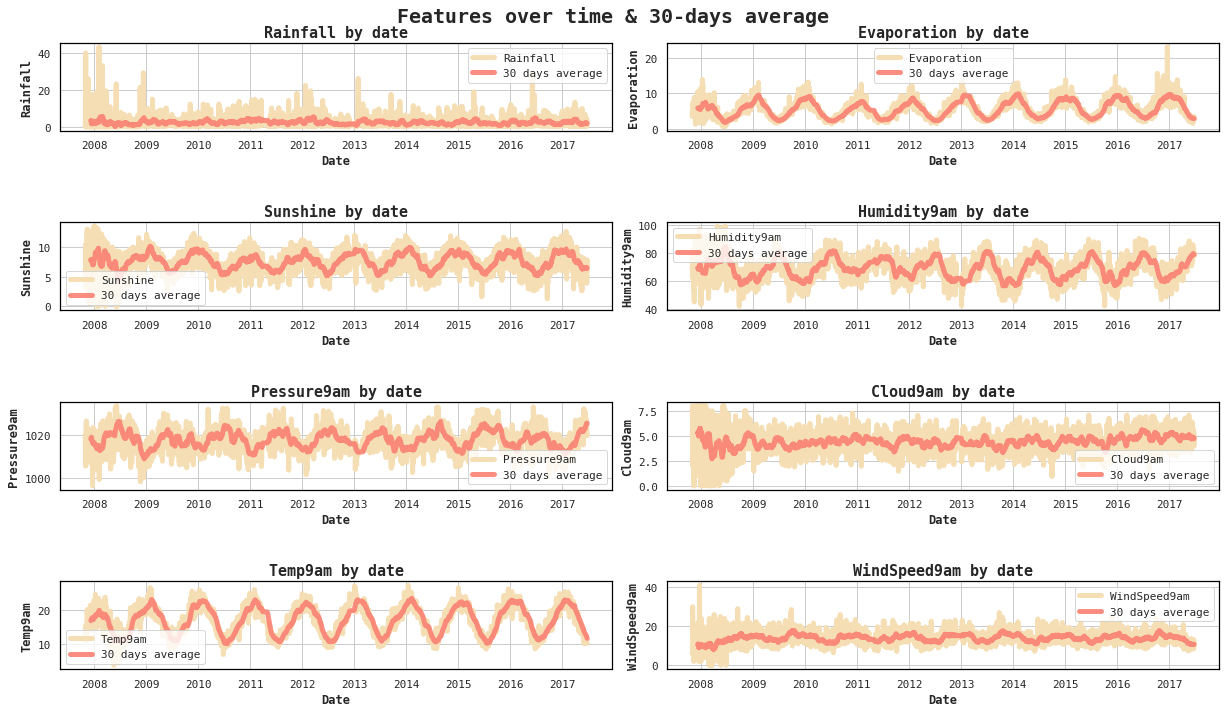

In [406]:
def plot_a_field_over_time(feature, ax, low_pass_filter_window = 30):
    """ plots the average value amoung different locations of a field over time """
    #plot settings:
    field_ts = train.groupby("Date")[field].mean()
    
    title = f"{field} by date"
    sns.lineplot(data=field_ts.rolling(1).mean(), label = feature,ax=ax,color=my_colors[2]).set_title(title,fontsize=15)
    sns.lineplot(data=field_ts.rolling(low_pass_filter_window).mean(), label = f"{low_pass_filter_window} days average",ax=ax,color=my_colors[1],alpha=0.9)

    
fig, ax = plt.subplots(ncols=2, nrows=4, figsize=(17,10))
title = 'Features over time & 30-days average'
fig.suptitle(title, fontsize=20, weight='bold')
index = 0
ax = ax.flatten()

for field in sample_features:
    plot_a_field_over_time(field,ax[index])
    index += 1
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=3.0)
plt.savefig(f"./images/{title}.png") 



## Preprocessing <a class="anchor" id="Preprocessing"></a> <a class="tocSkip">

#### Completing<a class="anchor" id="3.2"></a>

Next we would like to complete the missing values in our data. 

* The data varies significantly among different locations and time of year. Hence filling the missing values with the mean/median of the feature seems less desireable here. 
* A better approach would be to fill the missing values by the average of the feature in the same location and month. However, in many pairs of features and location most of data-points are missing. 
* Dropping all data-points with at least one missing entry will result in a loss of 60% of the data. 
* Dropping the fields with the highest number of missing values will result in a lost of the features with highest correlation to our y-label (Cloud, Sunshine etc).

To counter all of the problems above, I devised a three-stage process:
1. First, fill the missing values with the average of the past n-days mean values in the same feature and location. This approch utilizes the low turnover of the data acorss time (see autocorrelation bellow) and works only if at least one value exists in the n-days preceding the missing data-point. 
2. Second, using the data seasonality, fill the missing values with the historical monthly-average in the same location.
3. Finally, if a data point is still missing after steps 1-2, we conclude we don't have enough data to interpolate its values, and this datapoint is dropped. 

total number of data-points in train = 116368 
total number of data-points in after removing data-points with missing values = 45100 


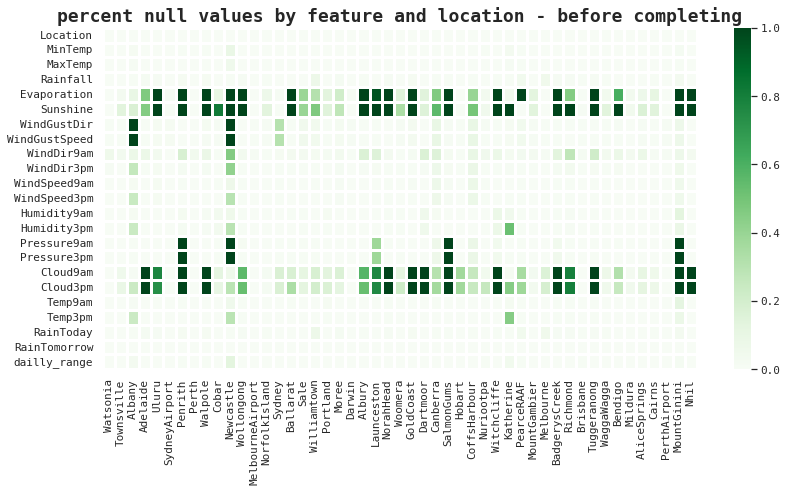

In [407]:
# Step 0: delete all data-points with missing y-label values
print(f"total number of data-points in train = {train.shape[0]} ")
train = train[train[y_label].notna()]
print(f"total number of data-points in after removing data-points with missing values = {train.dropna().shape[0]} ")

plot_nan_heatmap(train, "before completing")

In [408]:
wind_dir_features = ["WindGustDir", "WindDir9am", "WindDir3pm"] # don't fill wind direction data. 
features_to_fill = train.select_dtypes(np.number).columns.drop(wind_dir_features)

<AxesSubplot:title={'center':'Autocorrelation 1-day'}, ylabel='feature'>

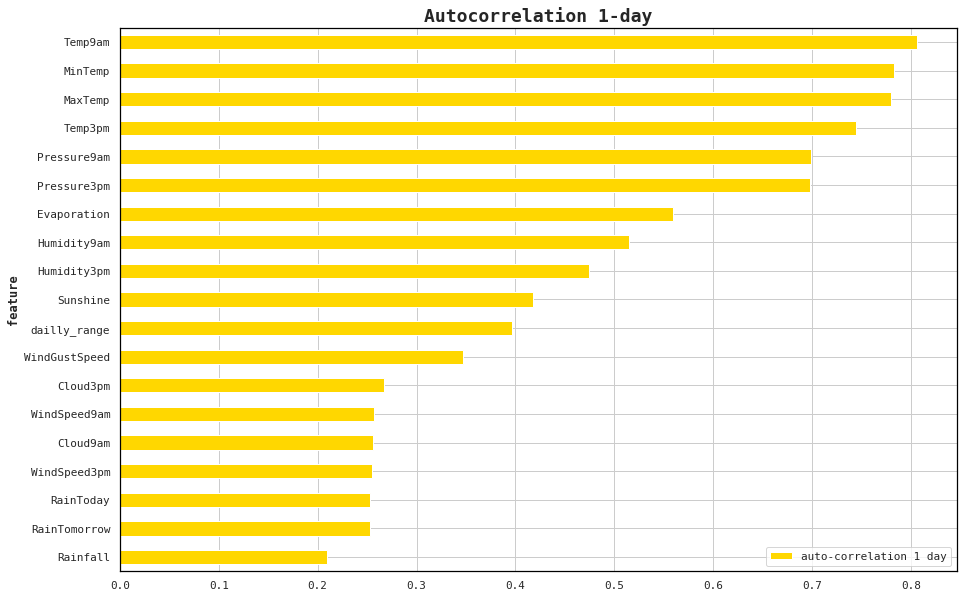

In [409]:
# step 1 - complete by the average of the feature and location in the past n-days

# for most features, the value today has some predictability for the value tomorrow. 
L=[]
for col in features_to_fill:
    mean = 0
    counter = 0
    for location in train["Location"].unique():
        tmp = train[train["Location"] == location].sort_values("Date")
        if not np.isnan(tmp[col].corr(tmp[col].shift(1))):                
            mean += tmp[col].corr(tmp[col].shift(1))
            counter+= 1
    L.append([col, mean/counter])
auto_corr = pd.DataFrame(L, columns = ["feature", "auto-correlation 1 day"])
auto_corr.index = auto_corr["feature"]
auto_corr.sort_values("auto-correlation 1 day", ascending=True).plot(kind='barh', figsize=(15,10),color=color,title="Autocorrelation 1-day")

total number of data-points in train = 47145 


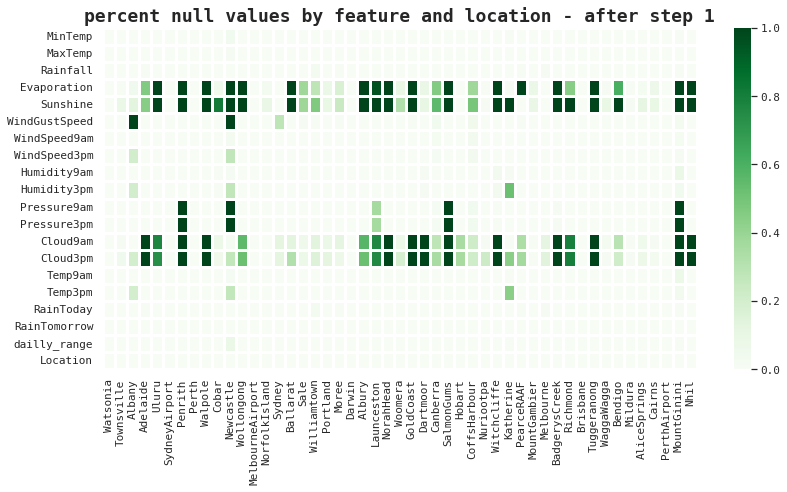

In [410]:
# number of days to look backwords
n_days = 7

# train
for col in features_to_fill:
    for location in train["Location"].unique():
        fillby = train[train["Location"] == location][col].shift(1).rolling(window=n_days).mean(skipna=True)
        train.loc[train['Location'] == location, col] = train[train["Location"] == location][col].fillna(fillby)
print(f"total number of data-points in train = {train.dropna().shape[0]} ")
plot_nan_heatmap(train[list(features_to_fill)+["Location"]], "after step 1")

total number of data-points after step 2 = 47145 


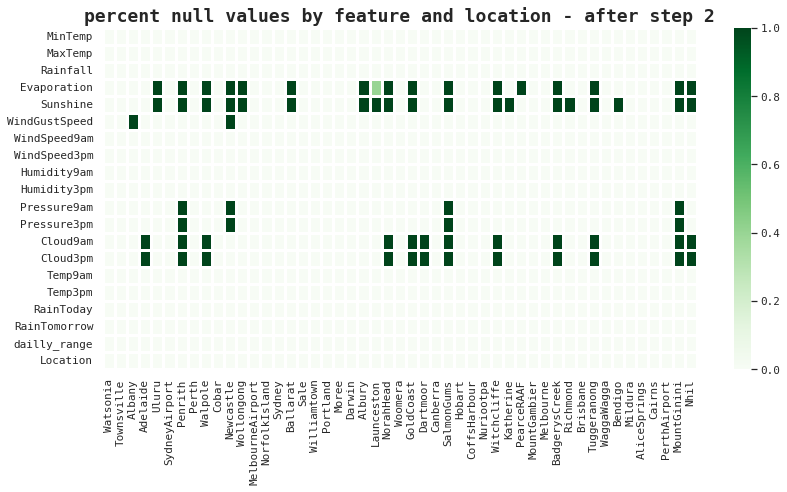

In [411]:
# step 2 - complete by the historical average of the feature, location and month

# get month of the year 
tmpy_train = train.copy()
months_train = tmpy_train.index.map(lambda x:x.month)

for col in features_to_fill:
    for location in train["Location"].unique():
        for month in range(1,13):
            # create dataframe of monthly averages:
            mask_train = (tmpy_train['Location'] == location) & (months_train == month)
            tmpy_train.loc[mask_train, col] = train[mask_train][col].mean(skipna=True) 
                        
print(f"total number of data-points after step 2 = {train.dropna().shape[0]} ")
# fill the missing values with the average value of the same location-month pair. 
train = train.fillna(tmpy_train)
plot_nan_heatmap(train[list(features_to_fill)+["Location"]], "after step 2")

total number of data-points in train = 58708 


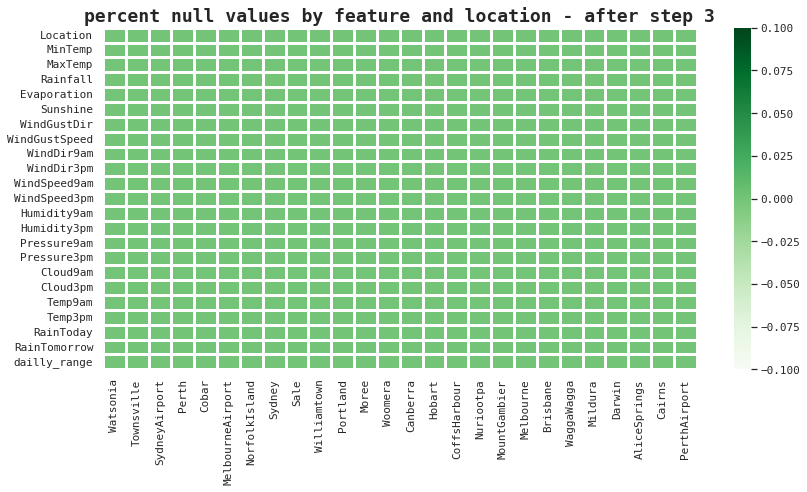

In [412]:
train = train.dropna(how="any")
test = test.dropna(how="any")
plot_nan_heatmap(train, "after step 3")
print(f"total number of data-points in train = {train.dropna().shape[0]} ")

#### Correcting <a class="anchor" id="3.1"></a>
First we transform the categorical wind-direction data into numeric features. Ideally, this transformation $f: [0, 2\pi] \rightarrow\mathbb{R}^{n}$ should have three important properties:

1. f is a continues.
2. $f(0)=f(2\pi)$
3. f is one-to-one, ie angle1!= angle2 then f(angle1)!=f(angle2).

I choose to apply the following map:

$f: f(\theta) = (\sin(\theta), \cos(\theta))$

In [413]:
wind_dir_features= ['WindGustDir', 'WindDir9am', 'WindDir3pm']
for feature in wind_dir_features:
    train[f"{feature}_sin"] = train[feature].apply(lambda x: np.sin(x))
    train[f"{feature}_cos"] = train[feature].apply(lambda x: np.cos(x))
    test[f"{feature}_sin"] = test[feature].apply(lambda x: np.sin(x))
    test[f"{feature}_cos"] = test[feature].apply(lambda x: np.cos(x))

train.drop(labels=wind_dir_features ,axis=1, inplace=True)
test.drop(labels=wind_dir_features ,axis=1, inplace=True)

## Feature Creation / Selection <a class="anchor" id="Feature"></a> <a class="tocSkip">


1. As mentioned above, the morning and afternoon variables are correlated, hence we want to avoid using both of them. I choose to use the afternoon values as they show higher correlation to our y label. Additionally, we add the difference between the afternoon values and the morning values - to incorporate the information in the morning features without using correlated features. 

2. Since RainToday is a direct function of Rainfall (i.e. Rainfall>1$\rightarrow$ RainToday=1 else RainToday=0), we will drop RainToday, the feature with the less information. 

A few more ideas i had:
* Time series features - using previous days values as features
* normalizing the wind direction by location
* replcing the direction value by the frequency of raining days at this location and direction. 
* using locaiton as feature (hot encoding)

In [414]:
# create change-in-time features:
for feature in ["Humidity","Pressure", "WindSpeed"]:
    train[f"delta_{feature}"] = train[f"{feature}3pm"] - train[f"{feature}9am"]
    test[f"delta_{feature}"] = test[f"{feature}3pm"] - test[f"{feature}9am"]

train["temp_range"] = train["MaxTemp"] - train["MinTemp"]
test["temp_range"] = test["MaxTemp"] - test["MinTemp"]

                
features = [
    "delta_Humidity", "delta_Pressure", "delta_WindSpeed", "temp_range",
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed3pm',
 'Humidity3pm',
 'Pressure3pm',
 'Cloud3pm',
 'Temp3pm',
 'WindGustDir_sin',
 'WindGustDir_cos',
'RainTomorrow']
                
features_df = train[features]
features_df_test = test[features]

The most linear correlated features with RainTomorrow are:
Humidity3pm       -->  0.45 (abs)
Sunshine          -->  0.42 (abs)
Cloud3pm          -->  0.37 (abs)
temp_range        -->  0.34 (abs)
delta_Humidity    -->  0.27 (abs)
WindGustSpeed     -->  0.23 (abs)
Rainfall          -->  0.23 (abs)
Pressure3pm       -->  0.23 (abs)


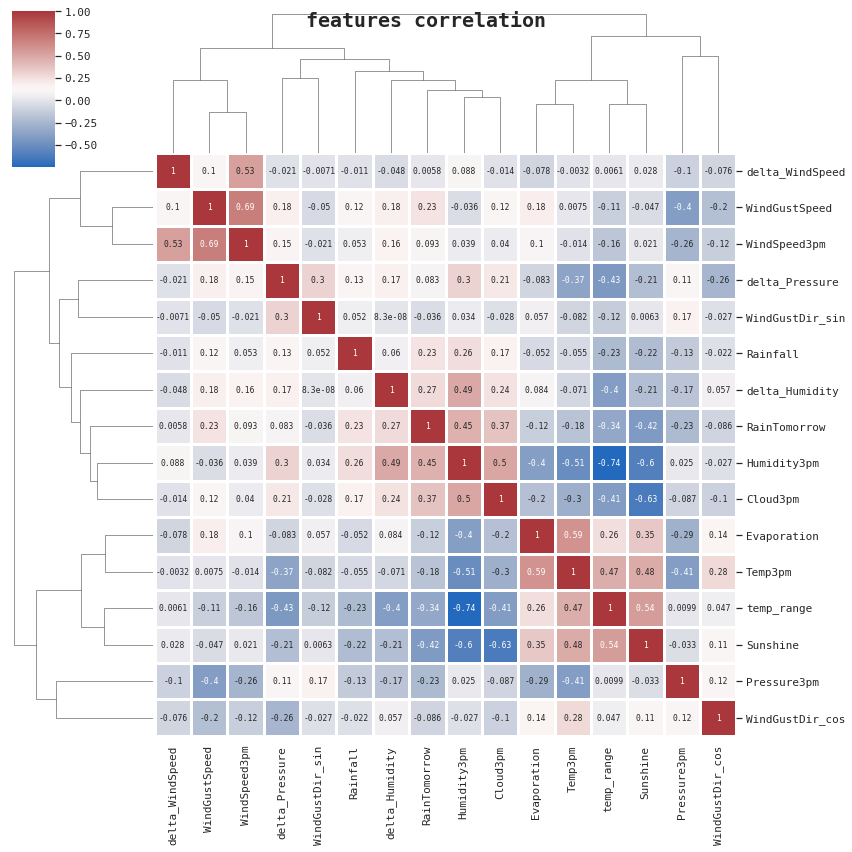

In [415]:
plot_features_correlation(features_df)

In [416]:
# define X and y:
y_train, y_test = features_df[[y_label]], features_df_test[[y_label]]
y_train, y_test = y_train.astype('int'),y_test.astype('int')
X_train, X_test = features_df.drop(y_label, axis=1), features_df_test.drop(y_label, axis=1)

## Random Forest <a class="anchor" id="RF"></a> <a class="tocSkip">

Next we train a random forest model to predict next day rainfall.


In [417]:
def plot_tree(classifier, max_depth=4):
    """ plots one tree, up to max_depth """
    fn=X_train.columns
    
    bool2str = lambda x:"Rain" if x==1.0 else "no rain"
    cn = np.array([bool2str(xi) for xi in classifier.classes_])

    fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=max(200*max_depth,300))  #make image clearer than default

    tree.plot_tree(classifier,
               feature_names = fn, max_depth=max_depth,
               class_names=cn,
               filled = True);

def plot_roc_curve(clf, train=True, ax=None):
    """ plots the ROC curve of the model """
    
    if train:
        X,y = X_train, y_train
    else:
        X,y = X_test, y_test
    y_proba = clf.predict_proba(X)[:,1]
    fpr, tpr, thresholds = roc_curve(y, y_proba)
    if ax is not None:
        sns.lineplot(x=fpr, y=tpr, color=color_main, ci=None, ax=ax)
        fig = sns.lineplot(x=thresholds, y=thresholds, color=my_colors[2], ci=None, linestyle = '--', ax=ax)
    else:
        sns.lineplot(x=fpr, y=tpr, color=color_main, ci=None)
        fig = sns.lineplot(x=thresholds, y=thresholds, color=my_colors[2], ci=None, linestyle = '--')
    fig.set_title("ROC curve")
    fig.set(xlim=(0, 1), ylim = (0,1))

    plt.xlabel('False positive rate (FP / N)')
    plt.ylabel('True positive rate (recall)')    


def evaluate(clf, train=True, feature_importance=True):
    """ prints and plots a custom score report for a sklearn classifer"""
    class_names = ["no_rain", "rain"]
    if train:
        X,y = X_train, y_train
    else:
        X,y = X_test, y_test
        
    # predict     
    y_predict = clf.predict(X)
    
    name = clf.__class__.__name__
    
    # score report
    print(classification_report(y, y_predict, target_names=class_names))
    
    # balance in prediction report
    print(f"""mean_of_predict={y_predict.mean():.2f} (actual = {y.values.mean():.2f}%)""")
    
    if feature_importance:
        # feature importance plot
        typey = "train" if train else "test"
        title = f"features importances for {name}, {typey}"
        cols = [i for i in X_train.columns if i!="Location"]
        feat_importances = pd.Series(clf.feature_importances_, index=cols)
        feat_importances.sort_values(ascending=True).plot(kind='barh',color=color)
        plt.suptitle(title, fontsize=20, weight="bold")
        return f1_score(y, y_predict)

def plot_scores(clf, train=True, ax=None, n_thresholds = 20):
    """ plots f1, recall and precision for different thresholds of the probabilities 
        returns the best threshold """
    if train:
        X,y = X_train, y_train
    else:
        X,y = X_test, y_test
       
    y_proba = clf.predict_proba(X)[:,1]
    rows = []
    thresholds = np.arange(0,1,1/n_thresholds)
    for thr in thresholds:
        if thr < 0.99:
            pred = (y_proba>thr).astype(int)
            rows.append([thr, f1_score(y,pred ), precision_score(y,pred ), recall_score(y,pred )])

    scores_by_thr = pd.DataFrame(rows, columns = ["thresholds","f1_score","precision_score","recall_score"])
    if ax is not None:
        fig = sns.lineplot(data=scores_by_thr, x='thresholds', y='f1_score', ci=None,color=color_main, label ="f1_score", ax=ax)
    else:
        fig = sns.lineplot(data=scores_by_thr, x='thresholds', y='f1_score', ci=None,color=color_main, label ="f1_score")
    sns.lineplot(data=scores_by_thr, x='thresholds', y='recall_score', ci=None,color=my_colors[3], label = "recall_score")
    sns.lineplot(data=scores_by_thr, x='thresholds', y='precision_score', ci=None,color=my_colors[1], label = "precision_score")

    fig.set(xlim=(0, 1), ylim = (0,1))
    fig.set_title("Model score as a function of prediction threshold", fontsize=20)
    plt.xlabel('threshold')
    plt.ylabel('Score')
    return scores_by_thr.sort_values("f1_score", ascending=False).iloc[0]['thresholds']

### Benchmark model
We set a benchmark model to better evaluate our model performance. Due to data imbalance, a simple "always predict no-rain" model has 78% accuracy. To maximize true positives and minimize false positives, we optimize all models with the metric precision and f1-score

In [418]:
dummy_clf = DummyClassifier(strategy='most_frequent', constant=0)
dummy_clf.fit(X_train, y_train)
evaluate(dummy_clf, feature_importance=False)

              precision    recall  f1-score   support

     no_rain       0.78      1.00      0.88     45830
        rain       0.00      0.00      0.00     12878

    accuracy                           0.78     58708
   macro avg       0.39      0.50      0.44     58708
weighted avg       0.61      0.78      0.68     58708

mean_of_predict=0.00 (actual = 0.22%)


### Parameters Tuning
parametres choice:

* **n_estimators** - the loss (in train and test) converges to the same value as a function of the number of trees. Hence, we choose to use large number of trees (e.g. 250).
* **criterion** - gini, entropy or accuracy - all of them or similiar. Gini and entropy are differentiable and hence more amenable to optimization. Entropy and gini are more sensitive to changes in the node probabilities than accuracy (e.g. improving the classificaiton from 0.7 to 0.8 will result in less of a reduction in the loss function compare to 0.8 to 0.9)
* **max_depth** - the depth of the trees is choosen using random search. Larger depth will exponentially incrsrease the complexity of the model (e.g. at depth of log_2 ( n ) for n number of samples, we would have 100% accuracy in during training ). Since we have 60k samples, max_depth of 15 = log2(60k) is an upper limit.
* **max_features** - Increasing max_features generally improves the performance of the model as at each node now we have a higher number of options to be considered. However, it will decrease the diversity among the trees. As a rule of thumb I use the standard sqrt(p) for p number of features. 
* **min_samples_split, min_samples_leaf** - other ways to restrict overfitting. In addition to searching for different values of max_depth, we will randomlly search for different design for the trees in those parametres
* **bootstrap** - we will use boostrap in our model to increase diversity among trees. 
* **class_weight** - our data is roughly 78-22% imbalance. We will oversample from the minority class to overcome the problems associated with imbalance prediction.

In [419]:
params_search = {
    'n_estimators':[50,250,500],
    'max_depth' : np.arange(5,22,2),
    'min_samples_split':np.arange(2,70,15),
    'min_samples_leaf': np.arange(2,30,10),
    'max_features':[round(np.sqrt(X_train.shape[1]))],
    'class_weight':['balanced',None],
    'max_samples':[0.1, 0.3,0.7],
    
    # set, but don't search the following:
        'criterion':['gini'],'bootstrap':[True],'oob_score':[True],
}

rf = RandomForestClassifier()
clf = RandomizedSearchCV(rf, params_search,  cv=2, scoring = ['accuracy', 'f1','precision','recall','roc_auc'],
                         refit=False, verbose=1,  n_iter=1000,return_train_score=True)

In [420]:
clf.fit(X_train, y_train.values.ravel())
results = pd.DataFrame(clf.cv_results_)

Fitting 2 folds for each of 1000 candidates, totalling 2000 fits


search results:
* Oversampling the minority class decaresses the accuracy but improves recall and f1 score. 

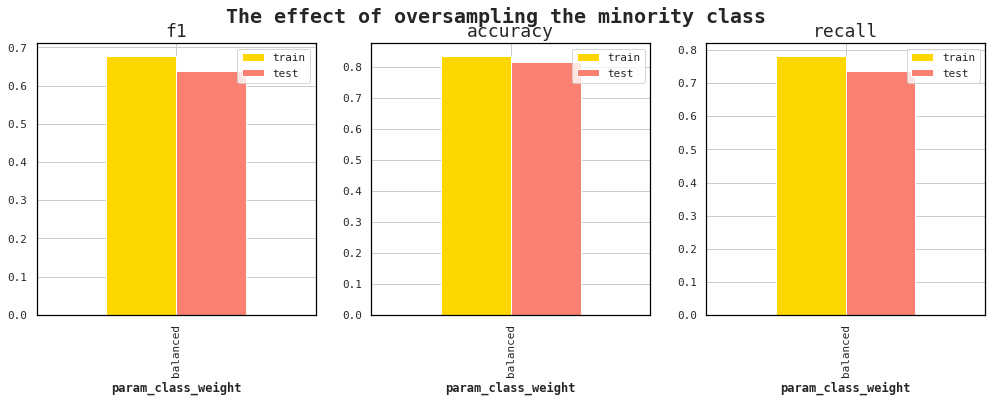

In [421]:
fig, ax = plt.subplots(ncols=3, nrows = 1, figsize=(17,5))
title = "The effect of oversampling the minority class"
fig.suptitle(title, fontsize=20, weight='bold')
tmp = results.groupby('param_class_weight').mean()
ax, index = ax.flatten(), 0

scores = ['f1', 'accuracy', 'recall']
for score in scores:
    tmp[[f"mean_train_{score}",f"mean_test_{score}"]].plot(kind='bar',color=[my_colors[0],my_colors[1]], ax=ax[index]).set_title(score,weight='regular')
    ax[index].legend(["train", "test"])
    index += 1
plt.savefig(f"./images/{title}.png") 


In [446]:
def performance_across_parms(search_obj, params_search,scoring_list=[],results=results):
    # params:
    if len(scoring_list) == 0:
        scoring_list = list(search_obj.scorer_.keys())
    parms_list = [parm for parm in params_search if len(params_search[parm]) > 1 and parm != 'class_weight']
    
    # plot settings:
    fig, ax = plt.subplots(ncols=2, nrows=((len(parms_list)*len(scoring_list))//2), figsize=(12,22))
    title = 'Score'
    #fig.suptitle(title, fontsize=20, weight='bold')
    index = 0
    ax = ax.flatten()
    for parm in parms_list:
        for score in scoring_list: 
            tmp = results[results['param_class_weight']=='balanced'].groupby(f'param_{parm}').mean()
            if tmp.index.is_numeric():
                sns.lineplot(data=tmp, x= tmp.index, y= f"mean_train_{score}", color=my_colors[0], ax=ax[index]).set_title(f"score={score}, parm={parm}", fontsize=15,weight='normal')
                sns.lineplot(data=tmp, x= tmp.index, y= f"mean_test_{score}",  color=my_colors[3], ax=ax[index])   
            index += 1
                
    plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=1)
    plt.savefig(f"./images/{title}.png") 

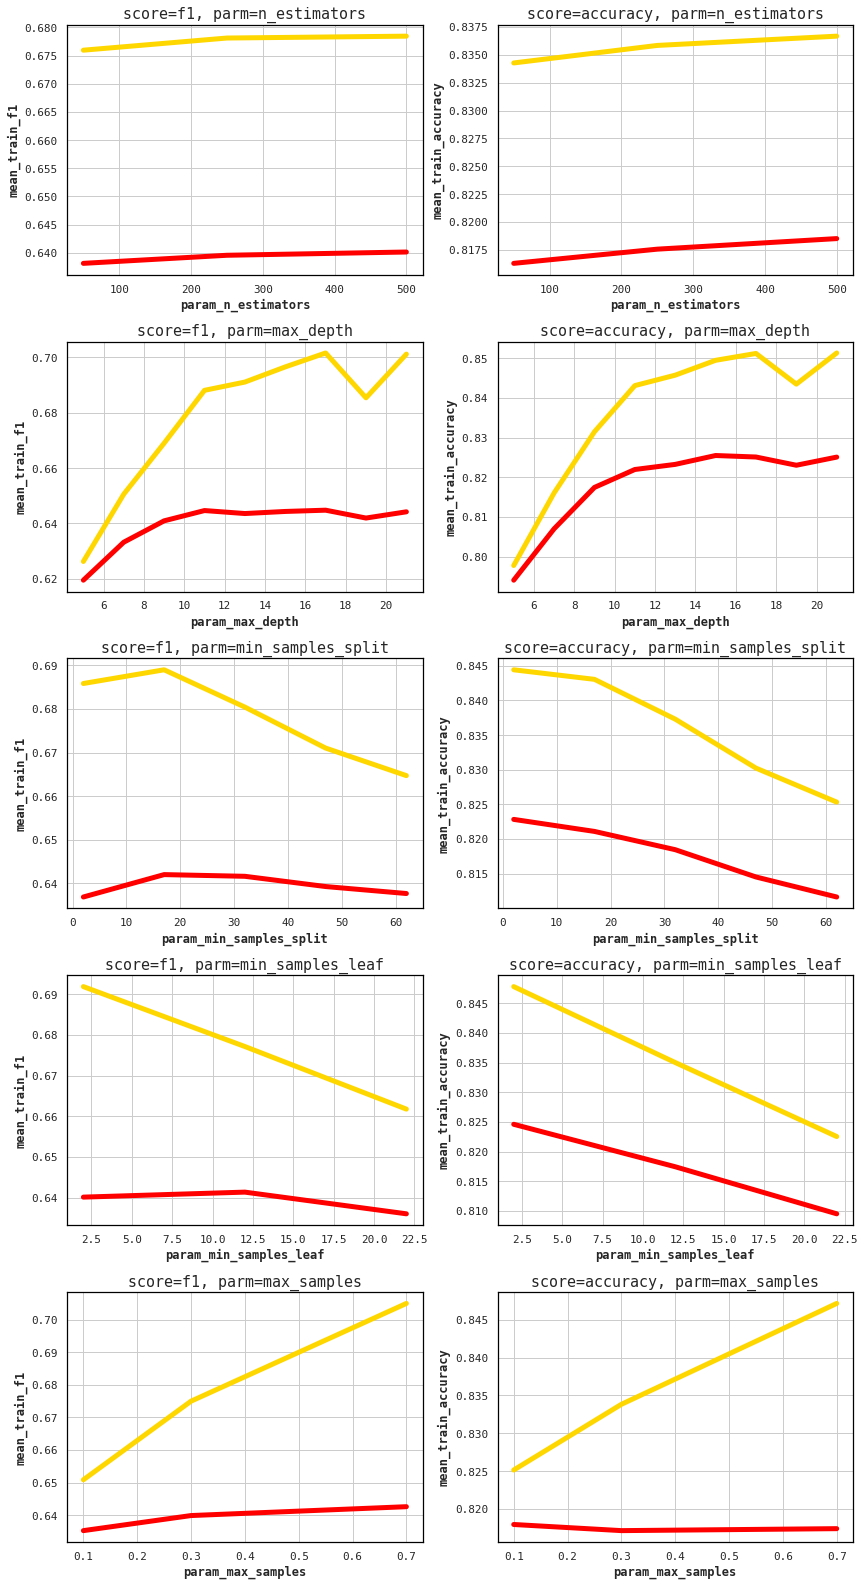

In [447]:
performance_across_parms(clf, params_search, scoring_list=['f1', 'accuracy'])

In [449]:
# choose the best params based on CV mean score:
score = 'f1'  # scoring func
params = results.sort_values(f'mean_test_{score}', ascending=False).iloc[0]['params']
print(params)

# fit model based on optimal params
rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train.values.ravel())

{'oob_score': True, 'n_estimators': 500, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_samples': 0.7, 'max_features': 4, 'max_depth': 21, 'criterion': 'gini', 'class_weight': 'balanced', 'bootstrap': True}


RandomForestClassifier(class_weight='balanced', max_depth=21, max_features=4,
                       max_samples=0.7, min_samples_leaf=2,
                       min_samples_split=17, n_estimators=500, oob_score=True)

              precision    recall  f1-score   support

     no_rain       0.97      0.94      0.95     45830
        rain       0.81      0.88      0.84     12878

    accuracy                           0.93     58708
   macro avg       0.89      0.91      0.90     58708
weighted avg       0.93      0.93      0.93     58708

mean_of_predict=0.24 (actual = 0.22%)


0.8438069047530566

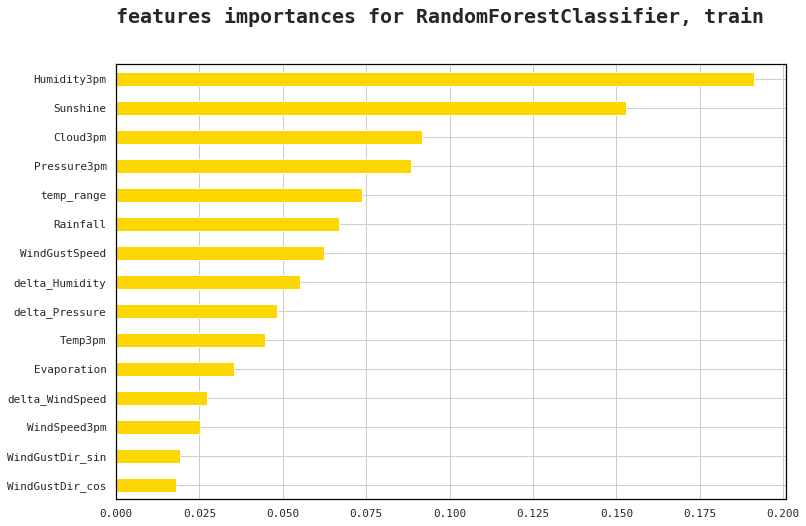

In [450]:
evaluate(rf, train=True)

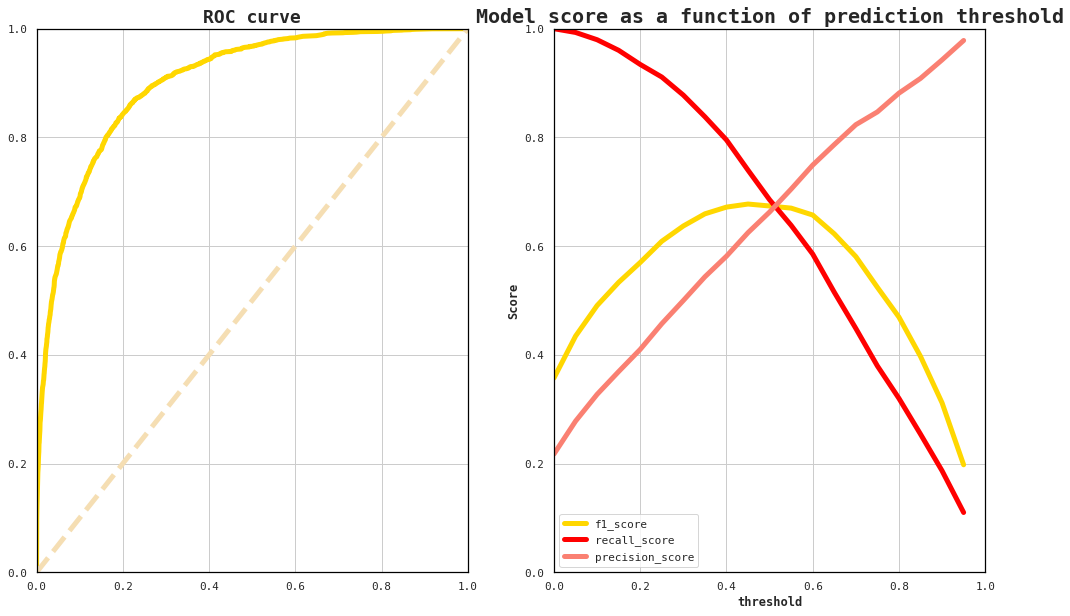

In [451]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(17,10))
index = 0
ax = ax.flatten()

# plot the ROC curve:
plot_roc_curve(rf, train = False, ax=ax[0])

# plot scores vs prediction thresholds:
best_thr = plot_scores(rf, train = False, ax=ax[1])
plt.savefig(f"./images/model_performance.png") 

### Final Model 

==== Train ==== 
              precision    recall  f1-score   support

     no_rain       0.98      0.92      0.95     45830
        rain       0.77      0.93      0.84     12878

    accuracy                           0.92     58708
   macro avg       0.87      0.92      0.89     58708
weighted avg       0.93      0.92      0.92     58708

model predicts rain 0.27 of days (actual=0.22)

==== Test ==== 
              precision    recall  f1-score   support

     no_rain       0.92      0.88      0.90      8857
        rain       0.62      0.74      0.68      2463

    accuracy                           0.85     11320
   macro avg       0.77      0.81      0.79     11320
weighted avg       0.86      0.85      0.85     11320

model predicts rain 0.26 of days (actual=0.22)


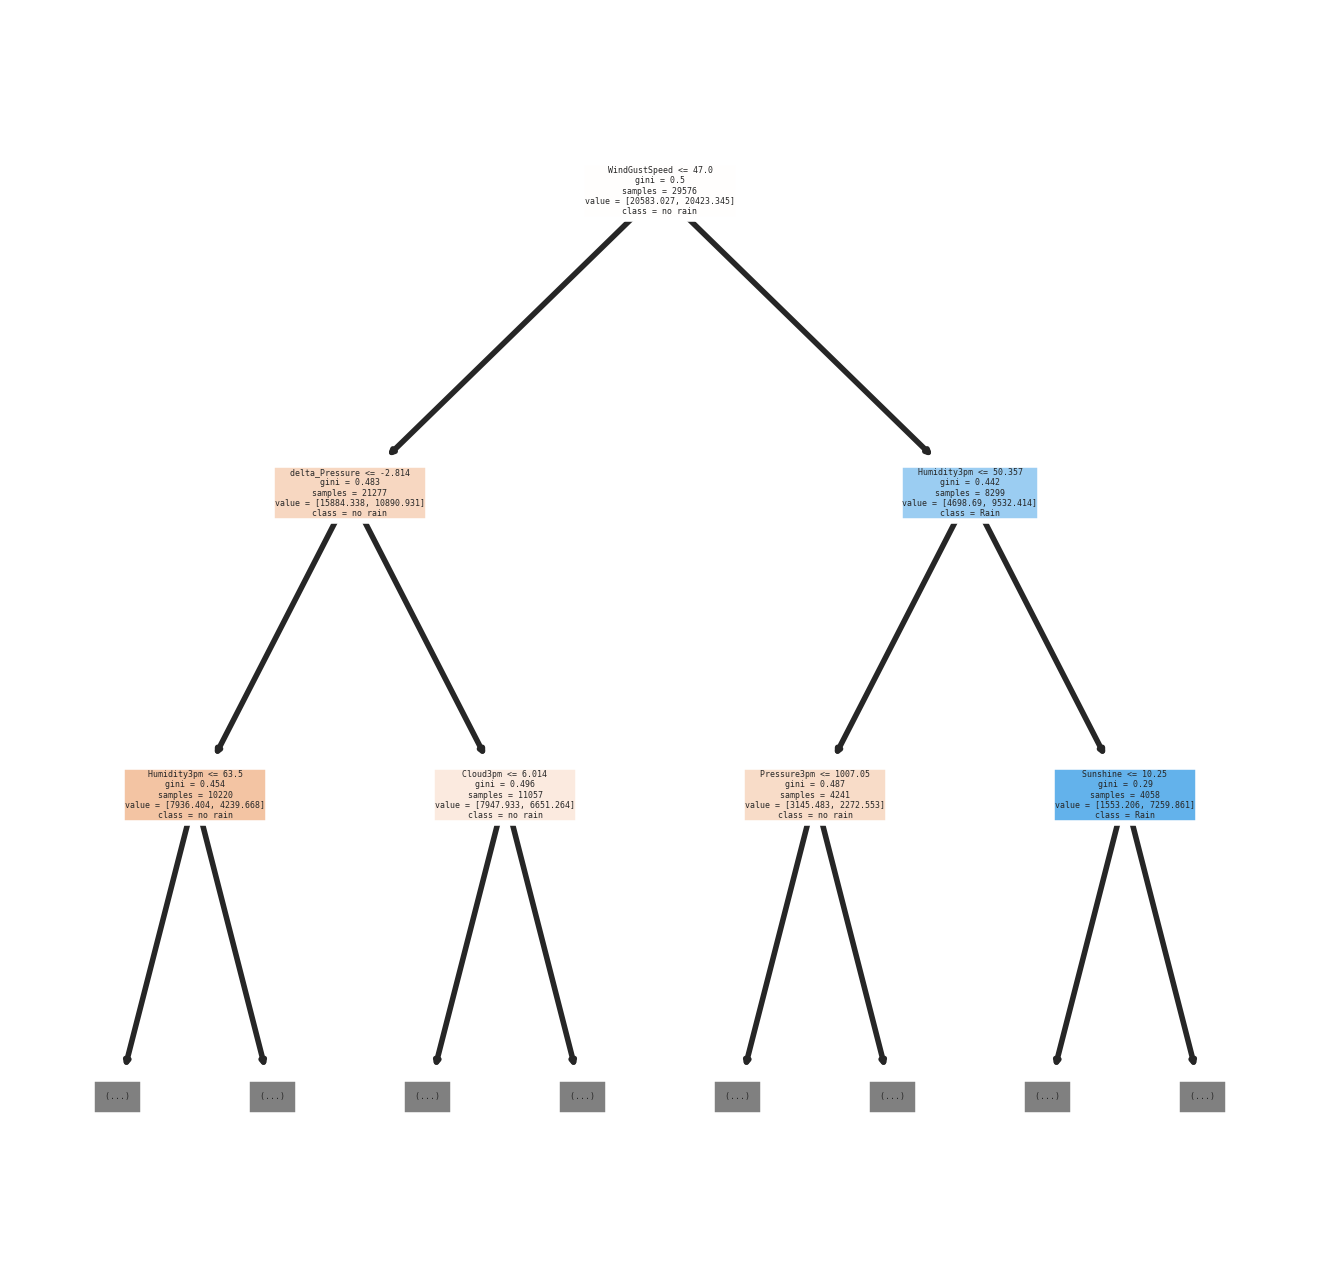

In [453]:
# choose threshold that maximizes f1 score in train 
thr = best_thr
class_names = ["no_rain", "rain"]

print("==== Train ==== ")
y_proba = rf.predict_proba(X_train)[:,1]
pred = (y_proba>thr).astype(int)
print(classification_report(y_train, pred, target_names=class_names))
print(f"model predicts rain {pred.mean():.2f} of days (actual={y_train.mean()[0]:.2f})")

print("\n==== Test ==== ")
y_proba = rf.predict_proba(X_test)[:,1]
pred = (y_proba>thr).astype(int)
print(classification_report(y_test, pred, target_names=class_names))
print(f"model predicts rain {pred.mean():.2f} of days (actual={y_test.mean()[0]:.2f})")

from sklearn import tree
plot_tree(rf.estimators_[0], 2)